In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.animation import FuncAnimation

%matplotlib inline
# %load_ext autoreload
# %autoreload 2

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import os
import seaborn as sns
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')
import pims
import pySPM as spm 
import trackpy as tp
import glob
from sxmreader import SXMReader
from mlviz import get_cam
from ipywidgets import interact
import ipywidgets as widgets

/home/a/as/asai/dsgo/trading/trading/lib/python3.5/site-packages/pySPM/utils/misc.py:135: UserWarning: the library tqdm cannot be found. All progressbar will be disabled.
  warn("the library tqdm cannot be found. All progressbar will be disabled.")


In [2]:
n_range = range(1 + 110, 1 + 110 * 2)
N = len(n_range)
SXM_PATH = ["electromigration_26/Image_{0:03}.sxm".format(i) for i in n_range]
frames = SXMReader(SXM_PATH)
molecule_size = 13
min_mass = 1.7
max_size = 3
separation = 5
searchRange = 30

Frame 109: 99 features


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f45f85b95f8>,
      dtype=object)

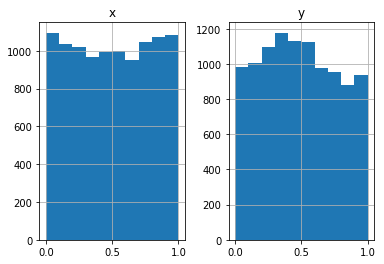

In [3]:
f = tp.batch(frames[:], 11, minmass=min_mass, maxsize=max_size, separation=separation)
tp.subpx_bias(f)

<Figure size 432x288 with 0 Axes>

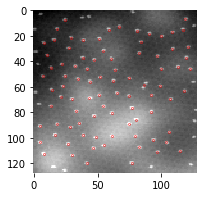

In [4]:
plt.figure()

fig=plt.figure(figsize=(4, 3))
ax1=plt.axes(xlim=(0, 256), ylim=(0, 256), frameon=False)
ln, = ax1.plot([], [], lw=3)
# plt.axis('off')

def update(i):
    tp.annotate(f[f['frame']==i], frames[i],  plot_style={'markersize': 0.5}, ax=ax1)
#     tp.annotate(f[f['frame']==i], frames[i],  plot_style={'markersize': 0,5}, ax=ax1)
    for line in ax1.lines[:-1]:
        line.set_marker(None)
    return ln,

ani = FuncAnimation(fig, update, frames=range(len(frames)), interval=100)
ani

Frame 109: 99 trajectories present.


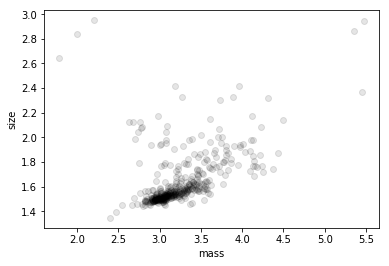

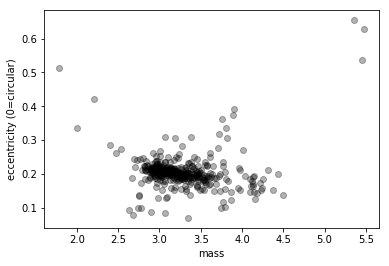

In [6]:
t = tp.link(f, search_range=searchRange, adaptive_stop=2.0, adaptive_step=0.95)
plt.figure()
tp.mass_size(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass
tp.mass_ecc(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass

In [7]:
t1 = t[( (t['size'] > 1) & (t['size'] < 1.8) & \
        (t['mass'] > 2.5) & (t['mass'] < 4.0) & \
         (t['ecc'] < 0.3)) ]
t2 = tp.filter_stubs(t, 10)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t2['particle'].nunique())

Before: 418
After: 223


In [8]:
# Get tracks longer than 31 and return 
long_t = t2.groupby('particle').filter(lambda x : len(x) > 31)
cropped_t = long_t.groupby('particle').head(31)
# cropped_t = cropped_t[cropped_t.particle == 3]

In [9]:
x_cams = cropped_t.groupby('particle')['x'].apply(lambda x: get_cam(x.values)[0])
y_cams = cropped_t.groupby('particle')['y'].apply(lambda y: get_cam(y.values)[0])

In [10]:
for p in cropped_t.particle.unique():
    cropped_t.loc[cropped_t.particle == p, 'x_cam'] = np.concatenate(([np.nan], x_cams[p], [np.nan]))
    cropped_t.loc[cropped_t.particle == p, 'x_cam'] /= cropped_t.loc[cropped_t.particle == p, 'x_cam'].mean()
    cropped_t.loc[cropped_t.particle == p, 'y_cam'] = np.concatenate(([np.nan], y_cams[p], [np.nan]))
    cropped_t.loc[cropped_t.particle == p, 'y_cam'] /= cropped_t.loc[cropped_t.particle == p, 'y_cam'].mean()
# cropped_t['avg_cam'] = (cropped_t['x_cam'] + cropped_t['y_cam']) / 2

/home/a/as/asai/dsgo/trading/trading/lib/python3.5/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/a/as/asai/dsgo/trading/trading/lib/python3.5/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


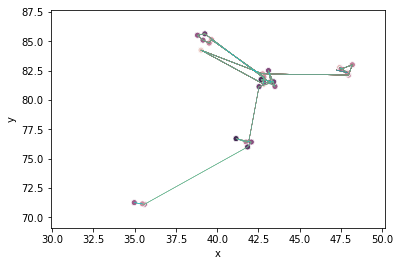

In [10]:
data = cropped_t.loc[cropped_t.particle == 3]
fig, (ax1) = plt.subplots(1)
ax1.clear()
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_xlim(np.min(data.x) - 2, np.max(data.x) + 2)
ax1.set_ylim(np.min(data.y) - 2, np.max(data.y) + 2)
# @interact(frame=widgets.IntSlider(min=0, max=30, step=1, value=1))
def update_figure(frame):
#     ax1.clear()
    tmp = data.iloc[:frame+1]
    sns.scatterplot(data=tmp, x='x', y='y', hue='avg_cam', hue_norm=(np.min(data.avg_cam), np.max(data.avg_cam)))
    sns.lineplot(data=tmp, x='x', y='y', lw=0.4, sort=False)
    ax1.get_legend().remove()
ani = FuncAnimation(fig, update_figure, frames=range(1,30), interval=500)
ani

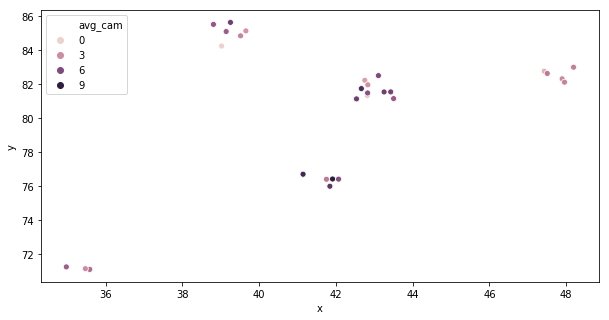

In [22]:
update_figure(30)